In [37]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from keras import backend as K

In [38]:
# Load data
data = np.load("data.npz")
X = data["arr_0"]
Y = data["arr_1"]
print("# Normal Images:", len(Y[np.where(Y == 0)]))
print("# Pothole Images:", len(Y[np.where(Y == 1)]))
print("# Total Images:", len(Y))

# Normal Images: 365
# Pothole Images: 1301
# Total Images: 1666


In [39]:
# Perform train-test split
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
# https://stackoverflow.com/questions/3674409/how-to-split-partition-a-dataset-into-training-and-test-datasets-for-e-g-cros
def shuffle(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]

def train_test_split(X, Y, test_prop):
  X, Y = shuffle(X, Y)
  split_index = int(test_prop * len(X))
  X_train = X[split_index:]
  Y_train = Y[split_index:]
  X_test = X[:split_index]
  Y_test = Y[:split_index]
  return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = train_test_split(X, Y, 0.3)
print("Total data:", X.shape)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Total data: (1666, 64, 64, 3)
Train shape: (1167, 64, 64, 3)
Test shape: (499, 64, 64, 3)


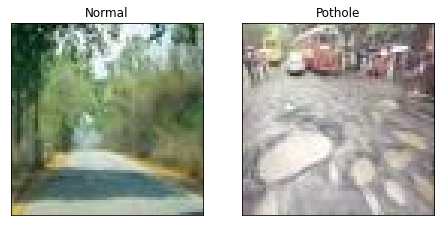

In [40]:
# Display sample images
class_names = ["Normal", "Pothole"]
fig = plt.figure(figsize=(20,10))
for i in range(len(class_names)):
  ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
  idx = np.where(Y_train[:]==i)[0]
  features_idx = X_train[idx,::]
  img_num = np.random.randint(features_idx.shape[0])
  im = features_idx[img_num,::]
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

In [41]:
# Loss functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [42]:
# Set hyperparameters
# Probably don't change these
input_width = 64
input_height = 64
input_depth = 3

num_epochs = 100
batch_size = 128
learning_rate = 0.0005
dropout_rate = 0.25 # This is multiplied by 2 at some point so should be <0.5 or change the usage

In [43]:
# Max Norm Constraints w/Dropout

# Initializing the model
model = Sequential()
# Defining a convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(input_width, input_height, input_depth)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_rate))
# We add our classificator
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_constraint=max_norm(3.)))
model.add(Dropout(dropout_rate * 2))
model.add(Dense(2, activation='softmax'))
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=learning_rate, decay=1e-6),
              metrics=['accuracy', f1_m, precision_m, recall_m])
# Training of the model
model.fit(X_train, to_categorical(Y_train),
          batch_size=batch_size,
          shuffle=True,
          epochs=num_epochs,
          verbose=2,
          validation_data=(X_test, to_categorical(Y_test)))
# Evaluation of the model
scores = model.evaluate(X_test, to_categorical(Y_test))
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

Metal device set to: Apple M1 Pro


2022-05-01 14:51:44.733784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-01 14:51:44.734283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2022-05-01 14:51:44.994025: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-01 14:51:45.565988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 - 2s - loss: 275.7729 - accuracy: 0.6667 - f1_m: 0.6784 - precision_m: 0.6784 - recall_m: 0.6784 - val_loss: 87.5040 - val_accuracy: 0.7675 - val_f1_m: 0.7666 - val_precision_m: 0.7666 - val_recall_m: 0.7666 - 2s/epoch - 175ms/step
Epoch 2/100


2022-05-01 14:51:46.598031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 - 1s - loss: 45.0105 - accuracy: 0.7446 - f1_m: 0.7319 - precision_m: 0.7319 - recall_m: 0.7319 - val_loss: 1.2273 - val_accuracy: 0.8597 - val_f1_m: 0.8591 - val_precision_m: 0.8591 - val_recall_m: 0.8591 - 630ms/epoch - 63ms/step
Epoch 3/100
10/10 - 1s - loss: 1.0555 - accuracy: 0.7421 - f1_m: 0.7472 - precision_m: 0.7472 - recall_m: 0.7472 - val_loss: 0.4359 - val_accuracy: 0.7796 - val_f1_m: 0.7785 - val_precision_m: 0.7785 - val_recall_m: 0.7785 - 631ms/epoch - 63ms/step
Epoch 4/100
10/10 - 1s - loss: 0.5562 - accuracy: 0.7892 - f1_m: 0.7902 - precision_m: 0.7902 - recall_m: 0.7902 - val_loss: 0.5581 - val_accuracy: 0.7695 - val_f1_m: 0.7685 - val_precision_m: 0.7685 - val_recall_m: 0.7685 - 634ms/epoch - 63ms/step
Epoch 5/100
10/10 - 1s - loss: 0.5592 - accuracy: 0.7858 - f1_m: 0.7870 - precision_m: 0.7870 - recall_m: 0.7870 - val_loss: 0.4123 - val_accuracy: 0.7695 - val_f1_m: 0.7685 - val_precision_m: 0.7685 - val_recall_m: 0.7685 - 597ms/epoch - 60ms/step
Epoch 6/100
10/

Epoch 35/100
10/10 - 1s - loss: 0.4388 - accuracy: 0.7866 - f1_m: 0.7760 - precision_m: 0.7760 - recall_m: 0.7760 - val_loss: 0.3201 - val_accuracy: 0.7675 - val_f1_m: 0.7666 - val_precision_m: 0.7666 - val_recall_m: 0.7666 - 591ms/epoch - 59ms/step
Epoch 36/100
10/10 - 1s - loss: 0.4492 - accuracy: 0.7866 - f1_m: 0.7819 - precision_m: 0.7819 - recall_m: 0.7819 - val_loss: 0.3562 - val_accuracy: 0.7675 - val_f1_m: 0.7666 - val_precision_m: 0.7666 - val_recall_m: 0.7666 - 586ms/epoch - 59ms/step
Epoch 37/100
10/10 - 1s - loss: 0.4336 - accuracy: 0.7866 - f1_m: 0.7878 - precision_m: 0.7878 - recall_m: 0.7878 - val_loss: 0.3208 - val_accuracy: 0.7675 - val_f1_m: 0.7666 - val_precision_m: 0.7666 - val_recall_m: 0.7666 - 587ms/epoch - 59ms/step
Epoch 38/100
10/10 - 1s - loss: 0.4351 - accuracy: 0.7866 - f1_m: 0.7937 - precision_m: 0.7937 - recall_m: 0.7937 - val_loss: 0.3065 - val_accuracy: 0.7675 - val_f1_m: 0.7666 - val_precision_m: 0.7666 - val_recall_m: 0.7666 - 587ms/epoch - 59ms/step


Epoch 68/100
10/10 - 1s - loss: 0.5696 - accuracy: 0.7875 - f1_m: 0.7945 - precision_m: 0.7945 - recall_m: 0.7945 - val_loss: 0.5784 - val_accuracy: 0.7695 - val_f1_m: 0.7685 - val_precision_m: 0.7685 - val_recall_m: 0.7685 - 587ms/epoch - 59ms/step
Epoch 69/100
10/10 - 1s - loss: 0.5689 - accuracy: 0.7866 - f1_m: 0.7937 - precision_m: 0.7937 - recall_m: 0.7937 - val_loss: 0.5770 - val_accuracy: 0.7695 - val_f1_m: 0.7685 - val_precision_m: 0.7685 - val_recall_m: 0.7685 - 586ms/epoch - 59ms/step
Epoch 70/100
10/10 - 1s - loss: 0.5655 - accuracy: 0.7883 - f1_m: 0.7894 - precision_m: 0.7894 - recall_m: 0.7894 - val_loss: 0.5757 - val_accuracy: 0.7695 - val_f1_m: 0.7685 - val_precision_m: 0.7685 - val_recall_m: 0.7685 - 588ms/epoch - 59ms/step
Epoch 71/100
10/10 - 1s - loss: 0.5649 - accuracy: 0.7875 - f1_m: 0.7827 - precision_m: 0.7827 - recall_m: 0.7827 - val_loss: 0.5744 - val_accuracy: 0.7695 - val_f1_m: 0.7685 - val_precision_m: 0.7685 - val_recall_m: 0.7685 - 586ms/epoch - 59ms/step


16/16 [==============================] - 0s 24ms/step - loss: 0.6694 - accuracy: 0.8517 - f1_m: 0.8555 - precision_m: 0.8555 - recall_m: 0.8555
Loss: 0.669
Accuracy: 0.852


In [44]:
Y_pred = model.predict(X_test)

# https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix
matrix = confusion_matrix(Y_test, Y_pred.argmax(axis=1))
matrix

2022-05-01 14:52:46.557255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 71,  45],
       [ 29, 354]])

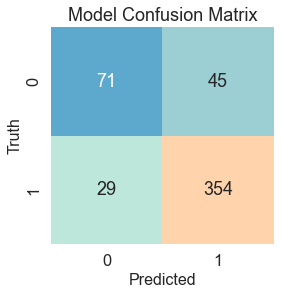

In [45]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
#https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
#https://www.tutorialspoint.com/how-to-hide-the-colorbar-of-a-seaborn-heatmap
#https://www.delftstack.com/howto/seaborn/set-axis-labels-seaborn-python/
#http://seaborn.pydata.org/tutorial/color_palettes.html

df_cm = pd.DataFrame(matrix, range(2), range(2))
plt.figure(figsize=(4,4))
sn.set(font_scale=1.5) # label size
p = sn.heatmap(df_cm, fmt='.3g', annot=True, annot_kws={"size": 18}, cbar=False, cmap="icefire")
p.set_xlabel("Predicted", fontsize = 16)
p.set_ylabel("Truth", fontsize = 16)
plt.title('Model Confusion Matrix')
plt.show()